# Multilayer Perceptron

- A final model in form of object built by <i>mlp_component</i> called MultilayerPerceptron
- methods in MultilayerPerceptron have its own purpose:
1. `__init__` : Define the required structure of mlp architecture 
2. `compile` : Specify how you want mlp to behave
3. `fit` : fit data with the given epoch, batch size, and more
4. `predict` : predicting input (**not test on regression, multi-classification yet** )

In [1]:
import import_ipynb

In [2]:
from mlp_component import *                          #linear_forward ,.... linear_backward_model
from compute_cost import *
from update_params import *
from debug_util import *                       # gradient_check_n
from initializer import *
from activation import *
from losses import *                    # binary_cross_entropy_loss
from load import data_loader
from metrics import accuracy_score


from utils.py_util import dictionary_to_vector, vector_to_dictionary, gradients_to_vector, pd_to_np

# %% External module
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from time import time
import math
from copy import deepcopy


importing Jupyter notebook from mlp_component.ipynb
importing Jupyter notebook from activation.ipynb
importing Jupyter notebook from regularization.ipynb
importing Jupyter notebook from compute_cost.ipynb
importing Jupyter notebook from losses.ipynb
importing Jupyter notebook from update_params.ipynb
importing Jupyter notebook from debug_util.ipynb
importing Jupyter notebook from C:\Users\Wallik\Desktop\dipple\nbdip\utils\py_util.ipynb
importing Jupyter notebook from initializer.ipynb
importing Jupyter notebook from load.ipynb
importing Jupyter notebook from metrics.ipynb


In [3]:
class MultilayerPerceptron:
    """
    A L-layer Perceptron Neural Network
    - Able to fit with the predictors (X) and the response (Y)
    - Able to predict_proba and predict with threshold
    
    To see the last fit model parameter, uses self.param where self refer to the fit model
    """

    def __init__(self, layer_dims : list , hidden_activation_function : str , output_activation_function : str ):
        
        """
        Launch the MultilayerPerceptron architecture with the given hyperparameter
        
        Arguments:
         1. layer_dims --- Number of units from input layer to output layer
         2. hidden_activation_function --- Activation function for all hidden layer(s) in forward model (relu,leakyrelu,tanh,sigmoid)
         3. output_activation_function --- Activation function for all hidden layer(s) in forward model (sigmoid,linear)
        """
        
        self.layer_dims = layer_dims
        self.L = len(layer_dims) - 1
        self.hidden_activation_function = hidden_activation_function
        self.output_activation_function = output_activation_function
        
        
    def compiles(self, lr = 1e-4, loss='binary_cross_entropy_loss', initialization = 'random' ,regularization = None ,
                 optimizer = None, **kwargs):
        """Compile options for training Deep-L layer Neural network
        
        Arguments
        ------------------------
        lr --- (initial) learning rate for gradient descent 
        
        loss : str --- loss function of the predicted value and the observation (default : binary_cross_entropy_loss_function)
                             [binary_cross_entropy_loss_function]
                 
        initialization --- weight initialization technique (default:random)
                             ['zero','random','xavier','he']
                            
        regularization --- regularization technique (default:None)
                             [None, 'L2','dropout']
        
        optimization (Not done) --- optimization technique (default:None)
                             [None, 'momentum' , 'nesterov_momentum' , 'adagrad' , 'rmsprop' , 'adam','nadam']
        
        Keyword Arguments
        ------------------------
        lambd ---   L2 Regularization parameter
                    *When regularization is 'L2'
        
        keep_prob_sequence --- Keep probability of the nodes for every layer
                                *When regularization is 'Dropout' 
        """
        
        _allowed_loss = {'binary_cross_entropy_loss'}
        _allowed_initialization = {'zero','random',
                                   'xavier','he'}
        
        _allowed_regularization = {'L2', 'L1',
                                   'dropout',
                                      None}

        _allowed_optimizer = {'momentum','nesterov_momentum',    
                              'adagrad','rmsprop',
                              'adam','nadam',
                                 None}
        
        assert loss in _allowed_loss,  'Invalid Loss: ' + loss
        assert initialization in _allowed_initialization,  'Invalid Initialization: ' + initialization
        assert regularization in _allowed_regularization,  'Invalid Regularization: ' + regularization
        assert optimizer in _allowed_optimizer,  'Invalid Optimizer: ' + optimizer        
        
        self.lr = lr
        
        map_loss = {'binary_cross_entropy_loss':binary_cross_entropy_loss}
        self.loss_function = map_loss[loss]
        self.initialization = initialization
        self.regularization = regularization
        self.optimizer = optimizer
        
        allowed_kwargs = {'lambd',
                          'keep_prob_sequence',
                          'beta1',
                          'use_nesterov',
                          'beta2',
                          'epsilon'}
        
        for kwarg in kwargs.keys():
            assert kwarg in allowed_kwargs, 'Invalid keyword argument: ' + kwarg
        
        if self.regularization:
            if self.regularization == 'L2': # Validate case for L2 regularization
                assert {'lambd'} <= set(kwargs), 'L2 Regularization needs lambd'
                #self.lambd = kwargs['lambd']  # deprecated

            elif self.regularization == 'dropout':
                assert {'keep_prob_sequence'} <= set(kwargs), 'Dropout Regularization needs keep_prob_sequence'
                #self.keep_prob_sequence = kwargs['keep_prob_sequence'] # deprecated
            
        if self.optimizer:
            if self.optimizer == 'momentum': #add beta but adam:beta1 beta2
                pass #beta1 
            
        self.kwargs_model = kwargs
        
    def fit(
        self,
        X: pd.DataFrame,
        Y: pd.Series,
        Epochs: int,
        batch_size:int=32 ,
        seed:int = 42,
        report_cost: bool = True,
        grad_check:bool = False,
        warmup: bool = False
    ):
        """
        Fit the launched Deep L layer with the given data X , Y

        Arguments:
         X --- Pandas Dataframe of predictors
         Y --- Pandas Series of response (0 : negative, 1:positive)
         Epoch --- number of epochs 
         batch_size --- Size of batch (Stochastic:1,Mini batch:around 1 and m, Batch: m) 
         seed --- Random seed for shuffling the row in DataFrame (for non-batch gradient descent)
         report_cost --- report the cost epochs every 1000 epoch
         grad_check --- Numerically test on the precision of backprop gradient
         warmup --- update param and save the parameter
        """
        self.X , self.Y = X, Y
        df = pd.concat([X,Y],axis=1)
        mini_batches : list = data_loader(df,batch_size,Y.columns)
        
        if not warmup:                                                            # ..Assign class attribute
            self.param = initiate_param(layer_dims = self.layer_dims,
                                            initialization = self.initialization)

        cost_list = []
        
        for epoch in range(1,Epochs+1):                                           # ..Each epoch
            cost = 0 
            
            for batch in range(len(mini_batches)):          
                                                                                  
                mini_batch = mini_batches[batch]                                  # ..Preprocessing Each batch
                mini_batch_X , mini_batch_y = mini_batch[0], mini_batch[1]
                
                mini_batch_X = mini_batch_X.to_numpy().T
                mini_batch_y = mini_batch_y.to_numpy().T
                m = mini_batch_y.shape[1]; # Size of each batch
                nrow = np.shape(mini_batch_X)[0] # Number of feature
                

                AL, cache = L_model_forward(mini_batch_X, self.param,                                 # ..Forward Prop
                                           hidden_activation_function=self.hidden_activation_function, 
                                           output_activation_function=self.output_activation_function,
                                            **self.kwargs_model )                                      # ..kwargs for dropout

                
                kwargs_regularization = {'lambd':self.kwargs_model['lambd'], 'param':self.param} if self.regularization in {'L2','L1'} else {}             
                cost += compute_cost(AL, mini_batch_y,                                           # ..Compute cost function for reporting to user only 
                                     self.loss_function,
                                     self.regularization,
                                     **kwargs_regularization)

                self.grads = L_model_backward(AL, mini_batch_y, cache,                          # ..Backward Prop                   
                                         self.hidden_activation_function,
                                        self.output_activation_function)

                if (grad_check and epoch % 1000 == 0):                                          # ..Gradient checking for every 1000 epochs
                    gradient_check_n(self.param , self.grads, mini_batch_X, mini_batch_y ,
                                    self.hidden_activation_function,
                                    self.output_activation_function,
                                    self.loss_function,
                                    self.regularization,
                                    **kwargs_regularization)
                    

                self.kwargs_model.update({'m': m})                                             # ..Update paramater by gradient
                self.param = update_params(param = self.param, 
                                          grads = self.grads, 
                                          lr=self.lr,
                                          regularization=self.regularization,
                                          optimizer=self.optimizer,
                                          **self.kwargs_model)                           #..kwargs for L2 regularization
                
            
            cost_list.append(np.squeeze(cost)/m)
            if (report_cost and epoch % 1000 == 0):
                print(f"Epoch {epoch}/{Epochs} : ===Cost=== : {np.squeeze(cost)/len(mini_batches)}")
        
        if report_cost:                                                      #..Done fitting and show plot of cost f.
            plt.plot(cost_list ,)       
            plt.xlabel("Epoch")
            plt.ylabel("Cost function")
            plt.show()
    
    @pd_to_np
    def predict(self, X: np.array, threshold: float = 0.5, predict_proba: bool = False):
        """Predict the observation given input X
        
        Arguments:
         X --- np.array of predictors with shape (m,n_x)
        """
        
        AL, _ = L_model_forward(X.T, self.param, 
                    hidden_activation_function=self.hidden_activation_function,
                    output_activation_function=self.output_activation_function   # linear if regression
                   )
        AL = pd.DataFrame(AL.T,columns=[self.Y.columns[0]])

        if self.output_activation_function == 'linear' or predict_proba:
            return AL
    
        elif self.Y.nunique()[0] == 2:
            print("binary classification")
            AL_ = np.where(AL>=threshold,1,0)
            return AL_
        
        else:
            print("Plan for multi-classification")
            pass
        
        


    
    @classmethod
    def initiate_by_hyperparam_dict(cls,hyperparam):
        """
        Launch the Deep_L_layer with the given hyperparameter in form of dictionary
        
        Arguments:
        hyperparam: A dictionary with key:
        
         layer_dims --- Number of units of that L layer
         lr --- Learning rate
         hidden_activation_function --- Activation function for all hidden layer(s) in forward model (relu,leakyrelu,tanh,sigmoid)
         last_hidden_activation_function --- Activation function for all hidden layer(s) in forward model (sigmoid,linear)
         
          {"layer_dims" : [ncol,8,6,4,2,1],
          "hidden_activation_function" : 'tanh' ,
          "output_activation_function" : 'sigmoid' }
          
        Supported activation
        """

        # Required hyperparameter attributes
        layer_dims = hyperparam['layer_dims']
        hidden_activation_function = hyperparam["hidden_activation_function"]
        output_activation_function = hyperparam["output_activation_function"]
        
        return cls(layer_dims,hidden_activation_function,output_activation_function)
    
    
    def __repr__(self):
        return f"MultilayerPerceptron({self.layer_dims}, {self.hidden_activation_function}, {self.output_activation_function})"

    def __str__(self):
        return f"A {self.L - 1} Layer Perceptron (Forward activation :{self.hidden_activation_function},Backward activation :{self.last_activation_function})"


---

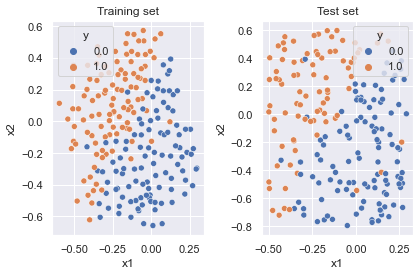

In [22]:
from import_dataset import Dataset_Library

dlib_borrow = Dataset_Library('football') #borrow football dataset
df_train, df_test = dlib_borrow.get_2df()

In [25]:
hyperparam_setting = {
              "layer_dims" : [2,8,6,4,2,1],
              "lr" : 1e-1,
              "hidden_activation_function" : 'relu',
              "output_activation_function" : 'sigmoid',}   


In [23]:
# Training
X = df_train[['x1','x2']]
Y = df_train[['y']]

✔️ Your backward propagation works perfectly fine! difference = 4.170764125642661e-09
✔️ Your backward propagation works perfectly fine! difference = 6.303790087129939e-09
✔️ Your backward propagation works perfectly fine! difference = 4.817602150655231e-09
✔️ Your backward propagation works perfectly fine! difference = 7.96923987216869e-09
✔️ Your backward propagation works perfectly fine! difference = 7.777032651909274e-09
✔️ Your backward propagation works perfectly fine! difference = 1.024282381628039e-08
✔️ Your backward propagation works perfectly fine! difference = 1.1650798706645127e-08
Epoch 1000/51000 : ===Cost=== : 0.6740317691381368
✔️ Your backward propagation works perfectly fine! difference = 4.45223746780898e-09
✔️ Your backward propagation works perfectly fine! difference = 3.069838758464008e-09
✔️ Your backward propagation works perfectly fine! difference = 5.832939181559492e-09
✔️ Your backward propagation works perfectly fine! difference = 9.458920128048583e-09
✔️ Y

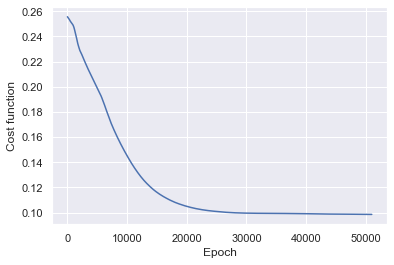

In [26]:

lambd = 0.0001

model = MultilayerPerceptron.initiate_by_hyperparam_dict(hyperparam_setting)
model.compiles(initialization='he',regularization="L2",lambd= lambd)
#model.compiles(initialization='he',regularization="dropout",keep_prob_sequence = [1,0.5,0.6,0.7,1,1])
model.fit(X,Y,Epochs=51000,batch_size=32,grad_check=True)

#acc = accuracy_score(Y,Y,model,title='He Initialization + L2 Regularization (On Training set)')
#print(f"Accuracy : {acc}")

In [ ]:
import pickle
#pickle.dump(model, open('model.pkl', 'wb'))
#model = pickle.load(open('sample_model/model_crescent.pkl', 'rb')) 

# In case for once fitting

binary classification


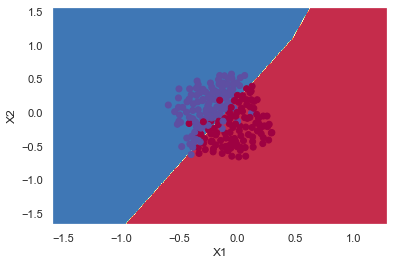

binary classification
0.9241706161137441


In [43]:
from interpret import plot_decision_boundary_2D

threshold = 0.5

plot_decision_boundary_2D(model=model,X=X,y=Y,threshold=threshold)
Y_pred = model.predict(X,threshold = threshold)
print(accuracy_score(Y_pred,Y))